/home/nataliagotkiewicz/miniconda3/envs/ds/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Katalog visualizations już istnieje. Wykresy będą zapisywane w tym katalogu.
Wczytywanie datasetu...
Wyświetlanie próbki audio:

Próbka audio #0
Emocja: surprised
Tekst: Ucho wykrywa dźwięki o różnej częstotliwości.
Speaker ID: WR0
Częstotliwość próbkowania: 24000 Hz
Długość nagrania: 2.94 sekund

Odtwarzanie audio:


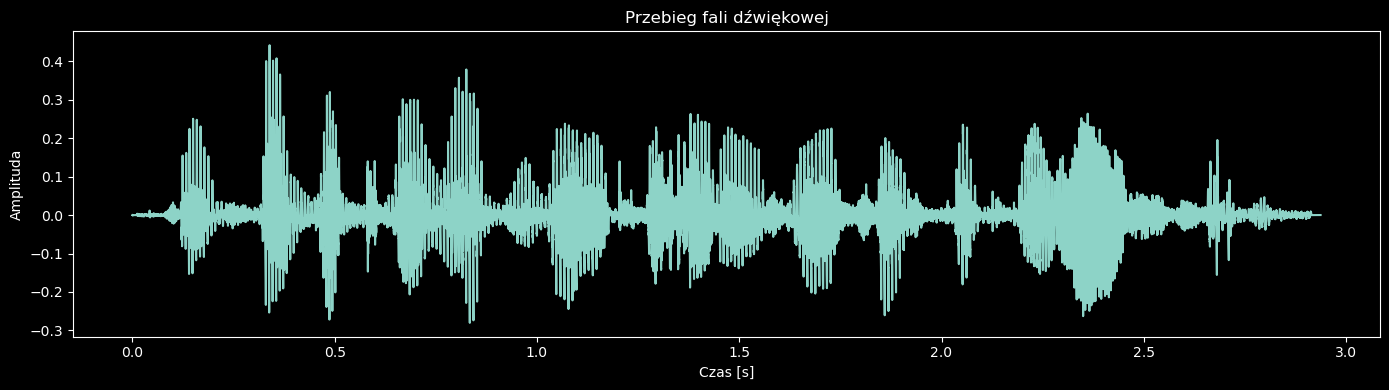

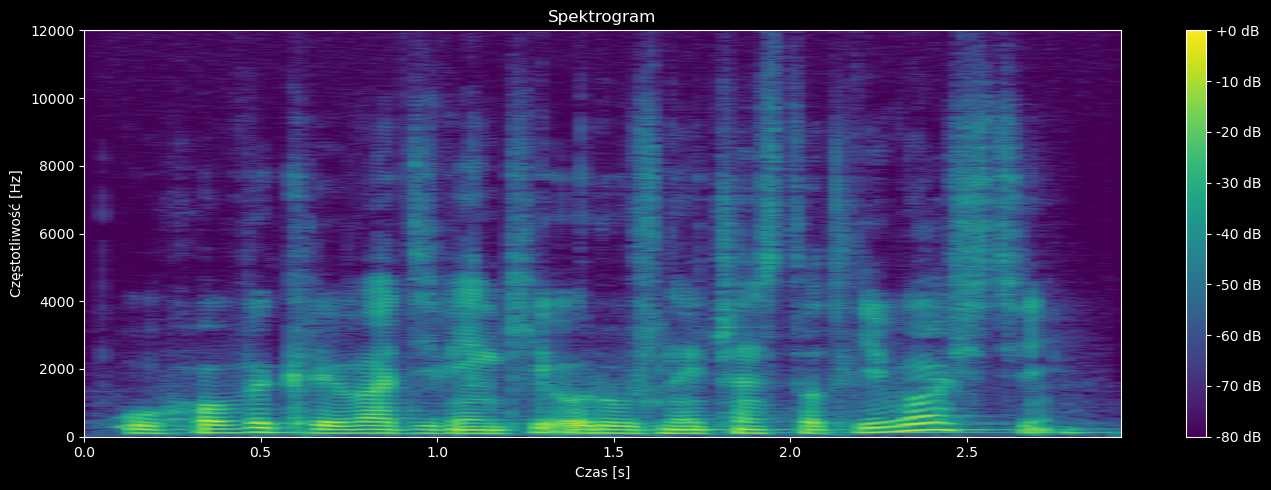

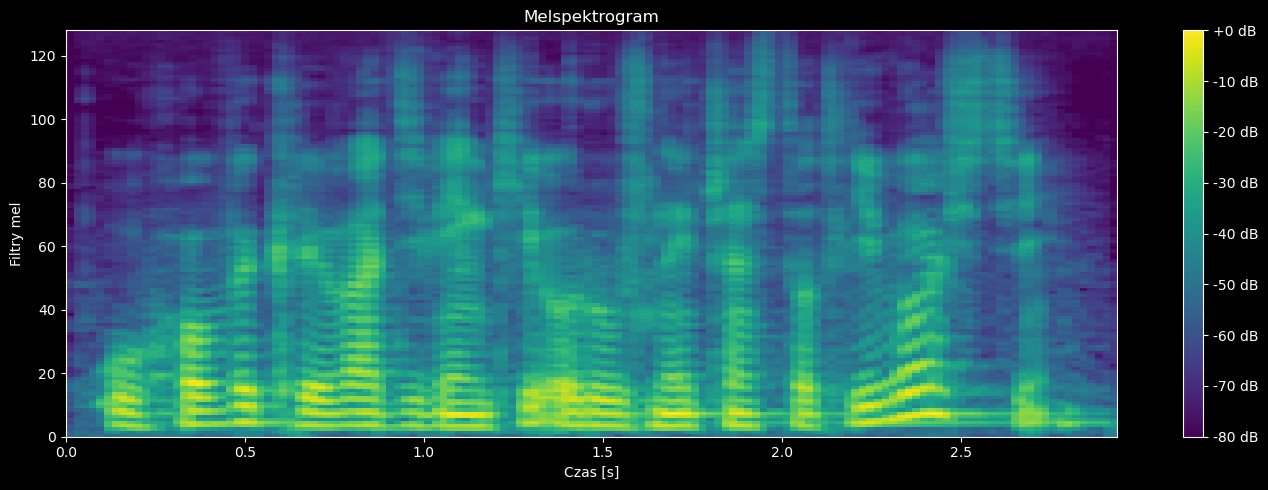

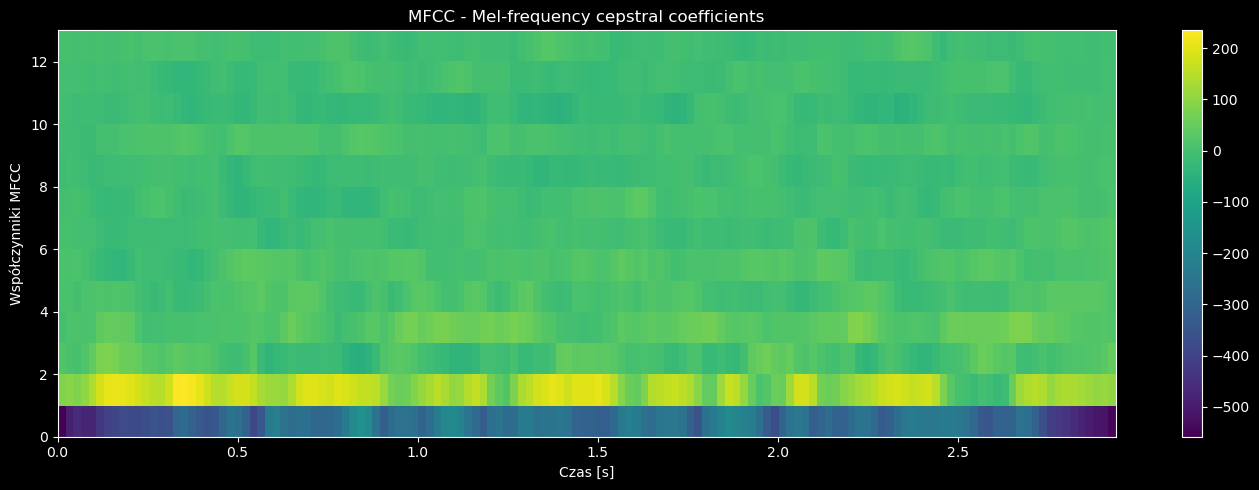

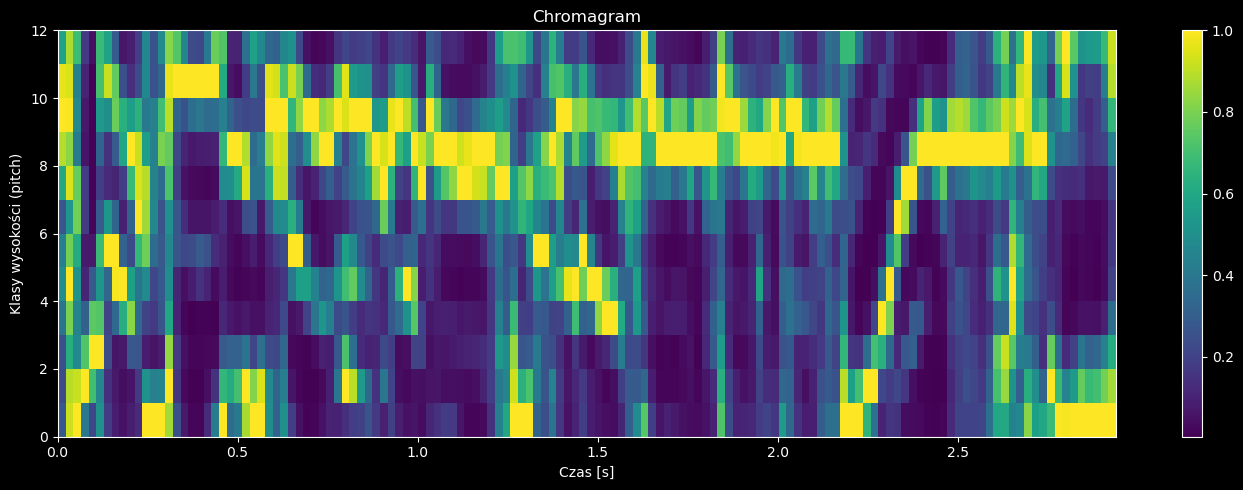

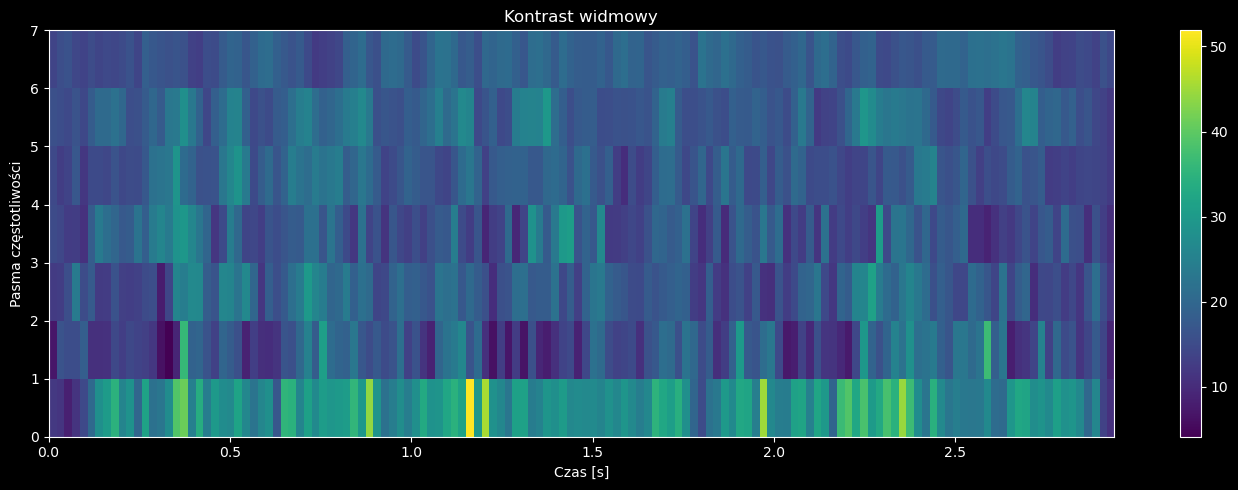

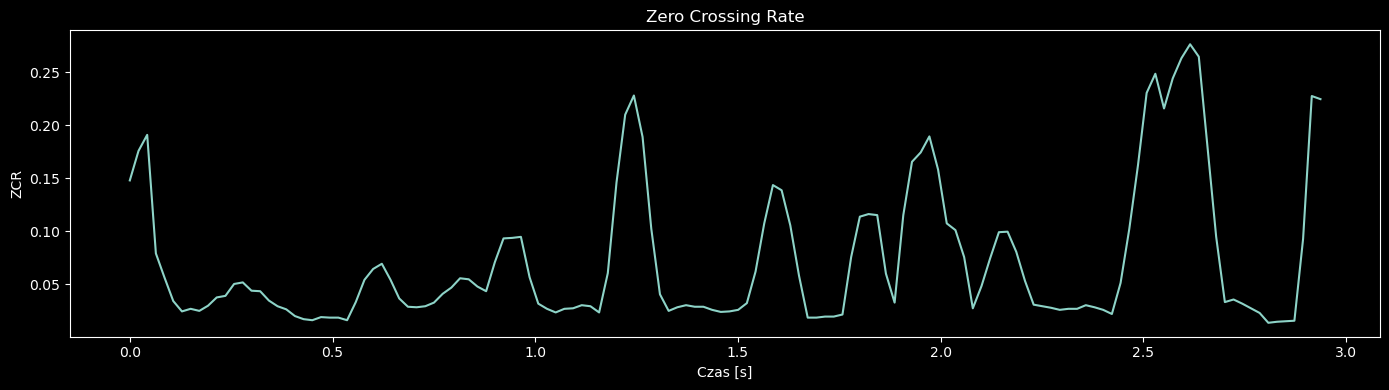

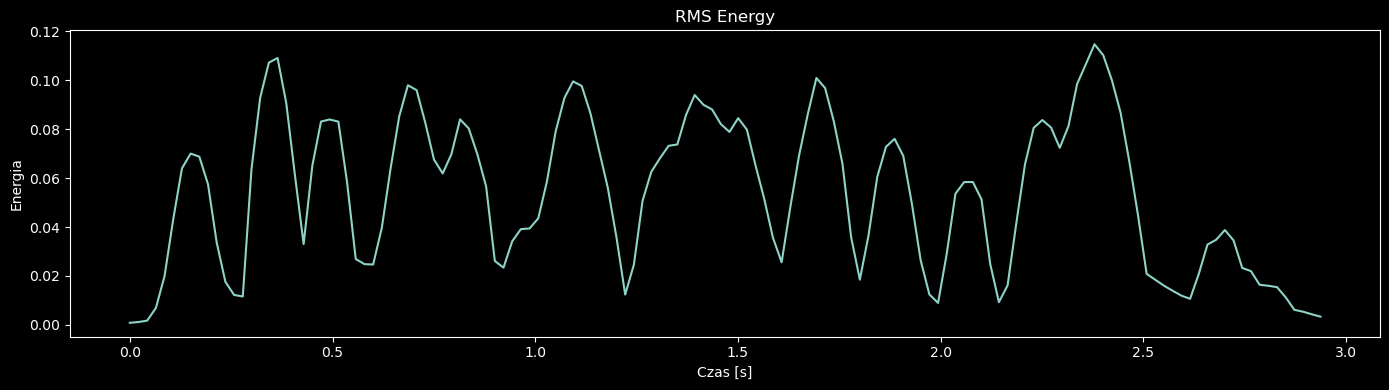

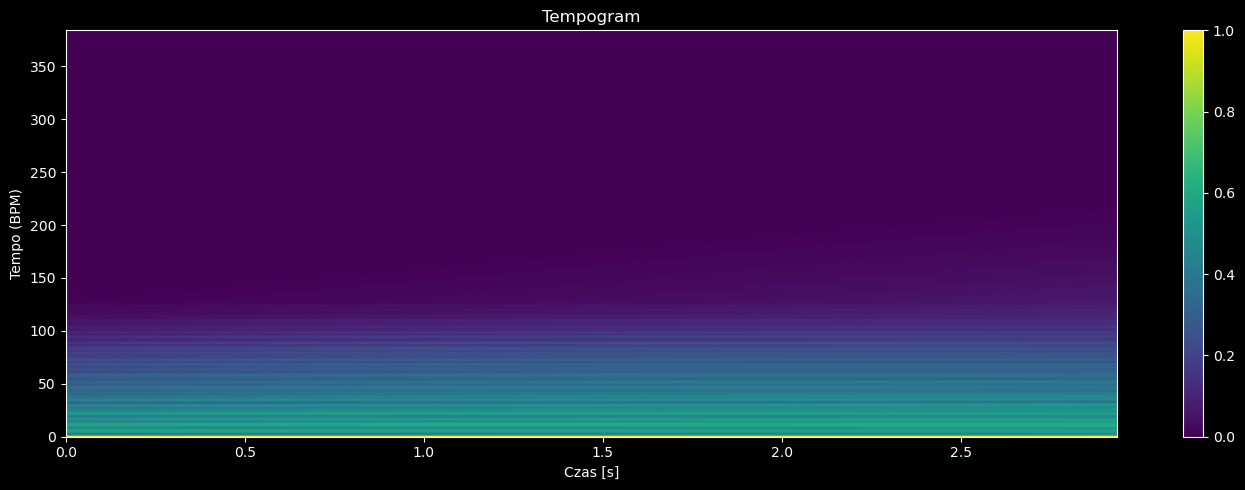

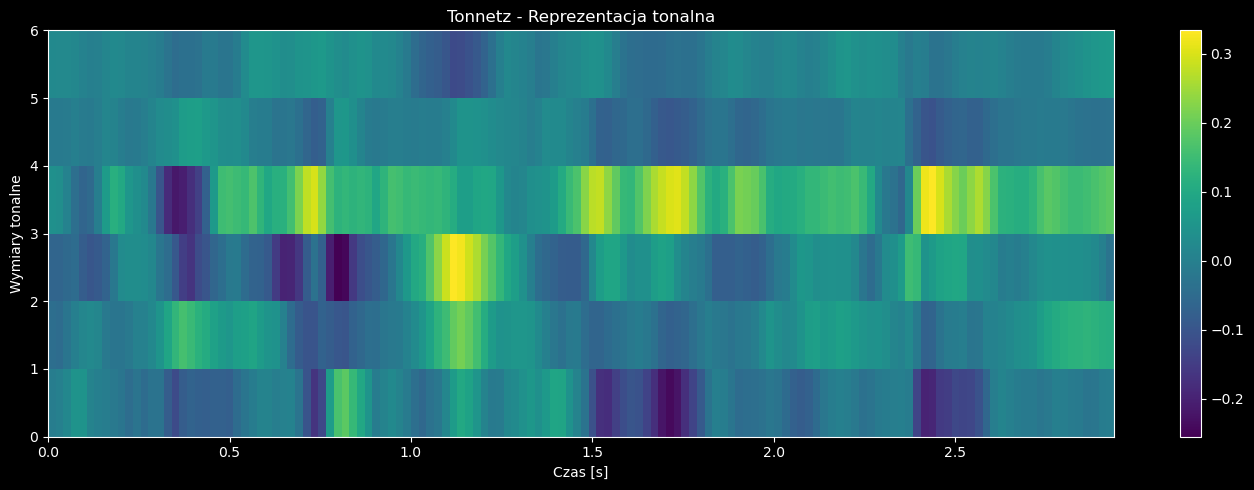

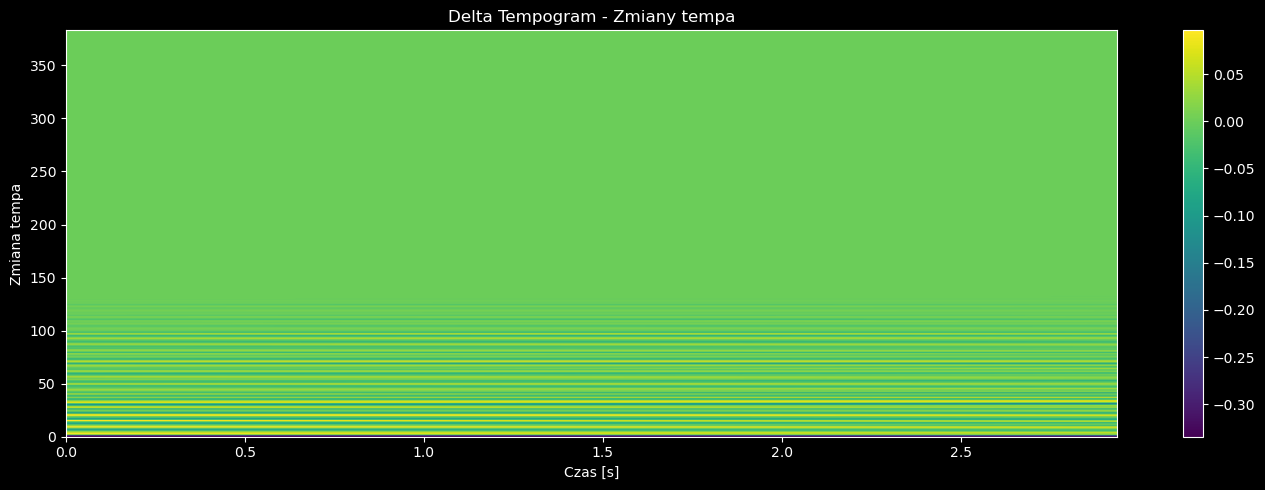

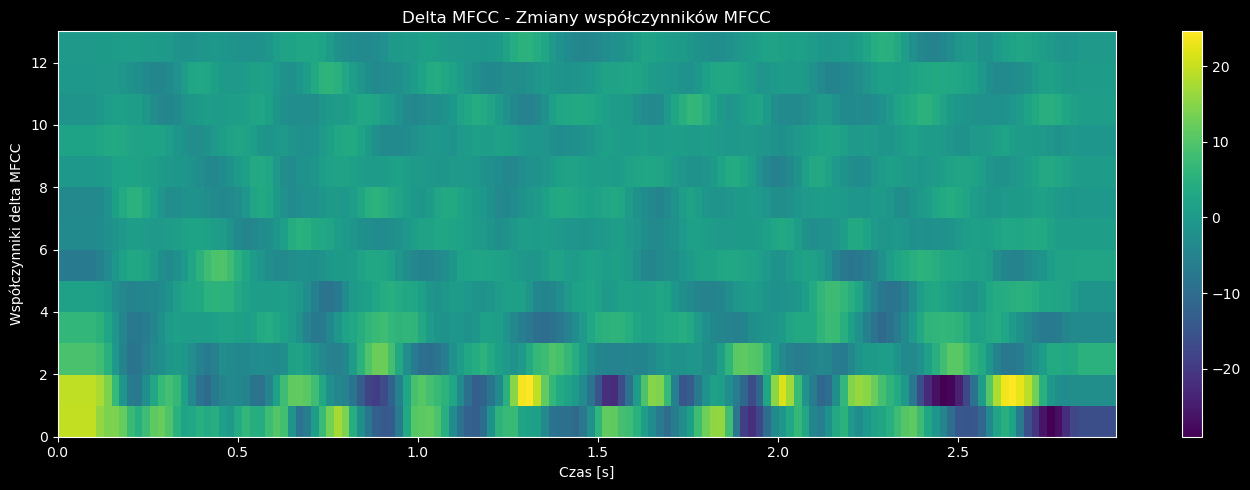

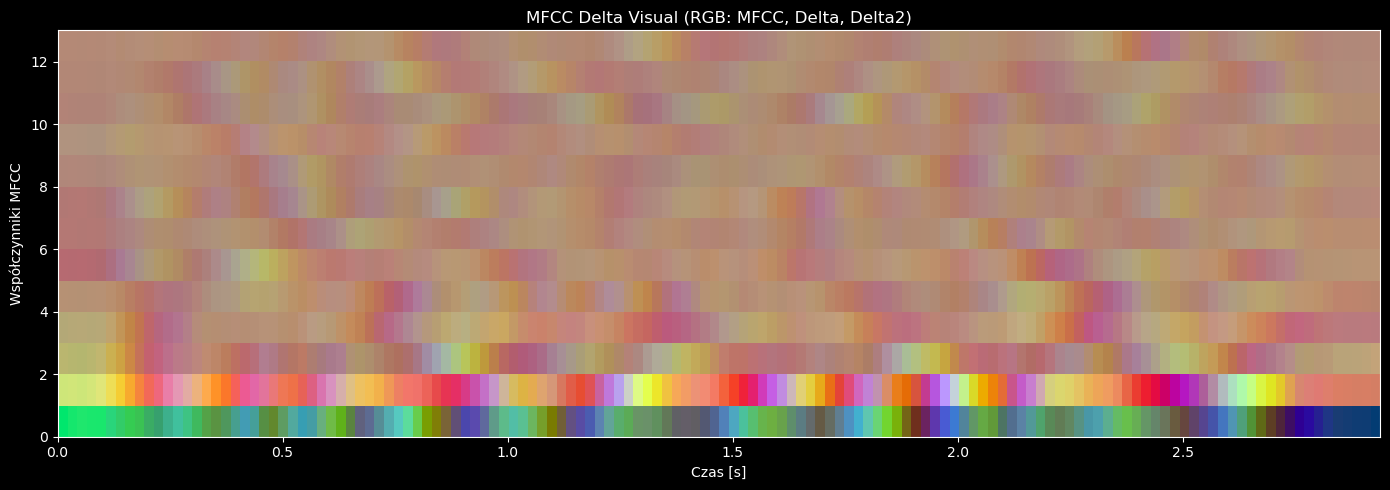

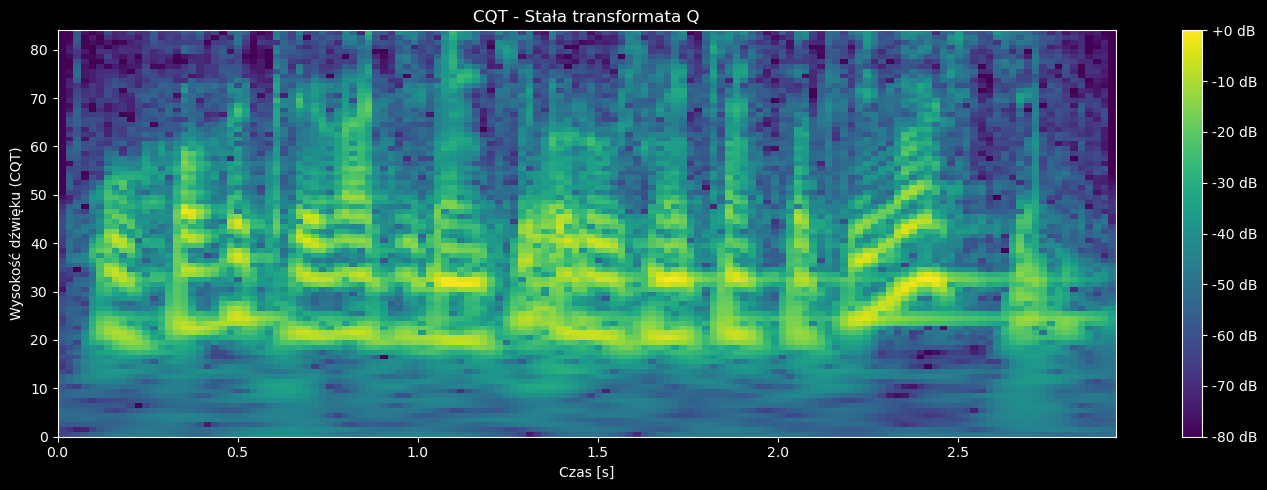

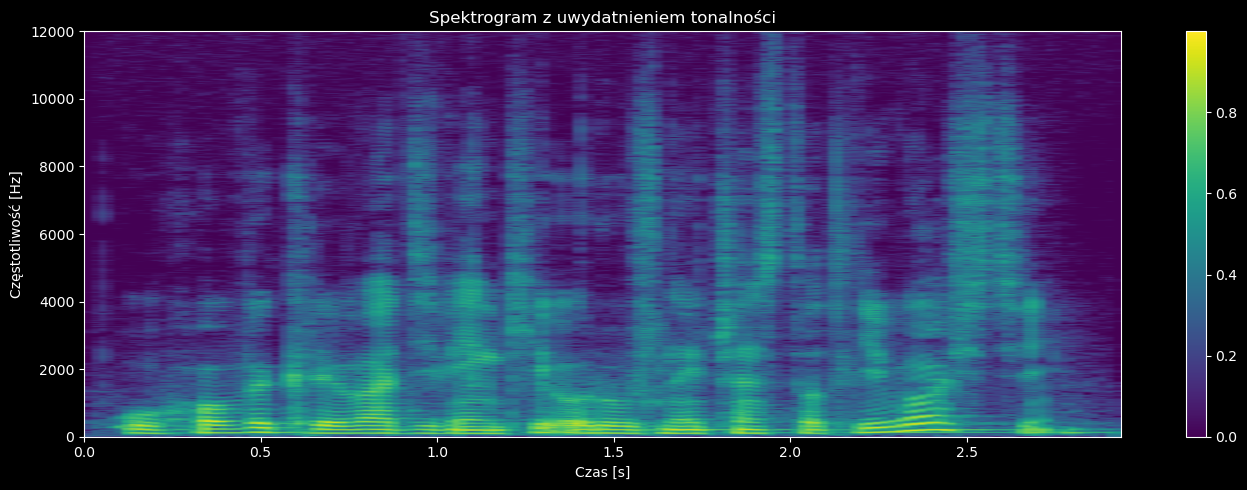

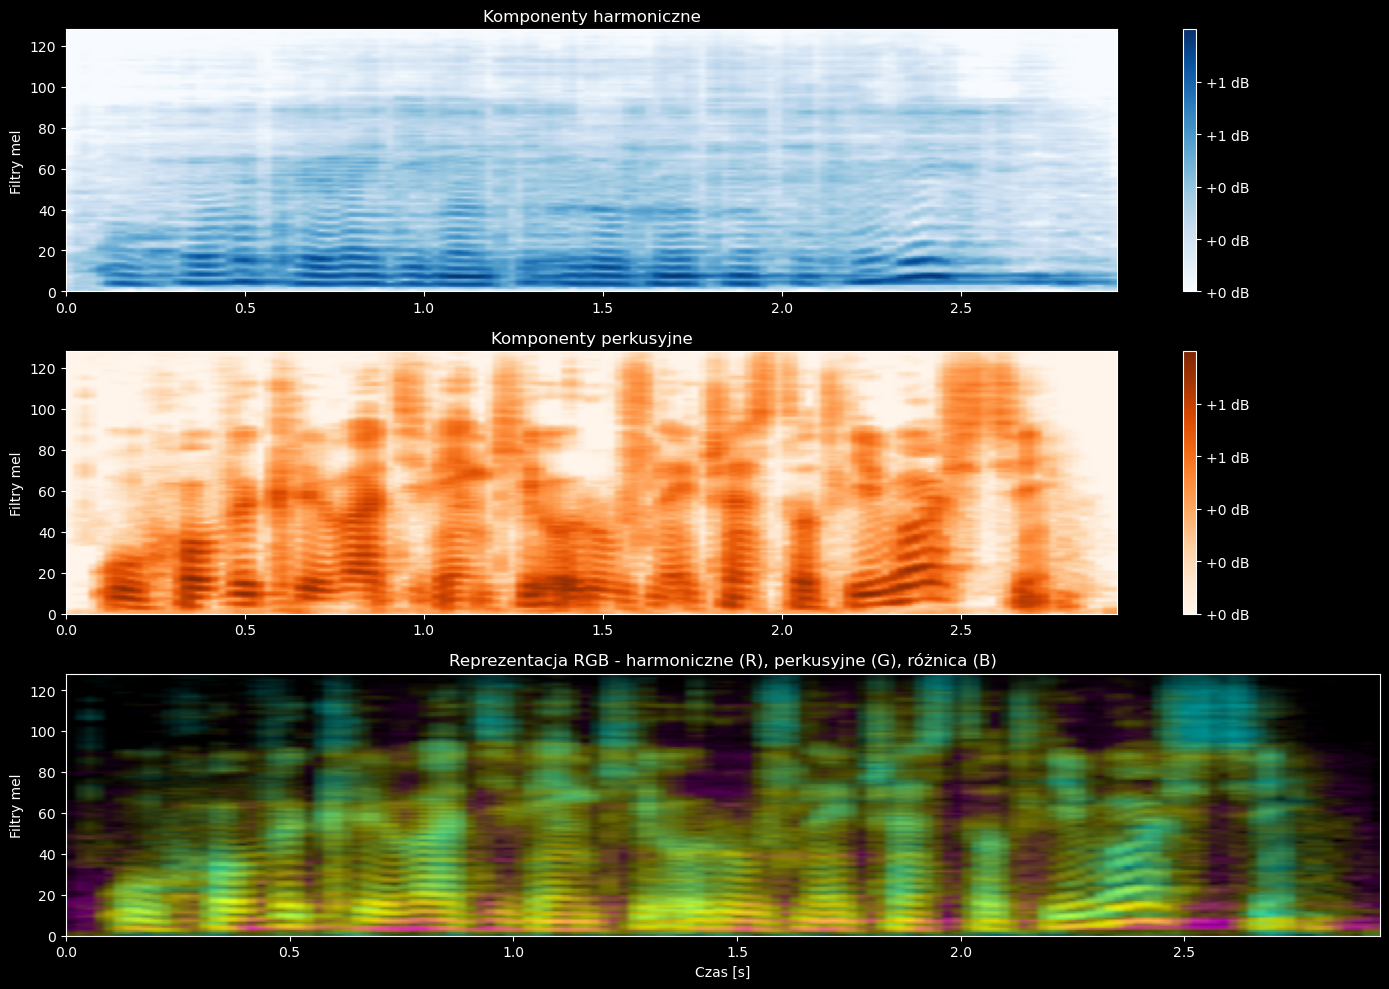

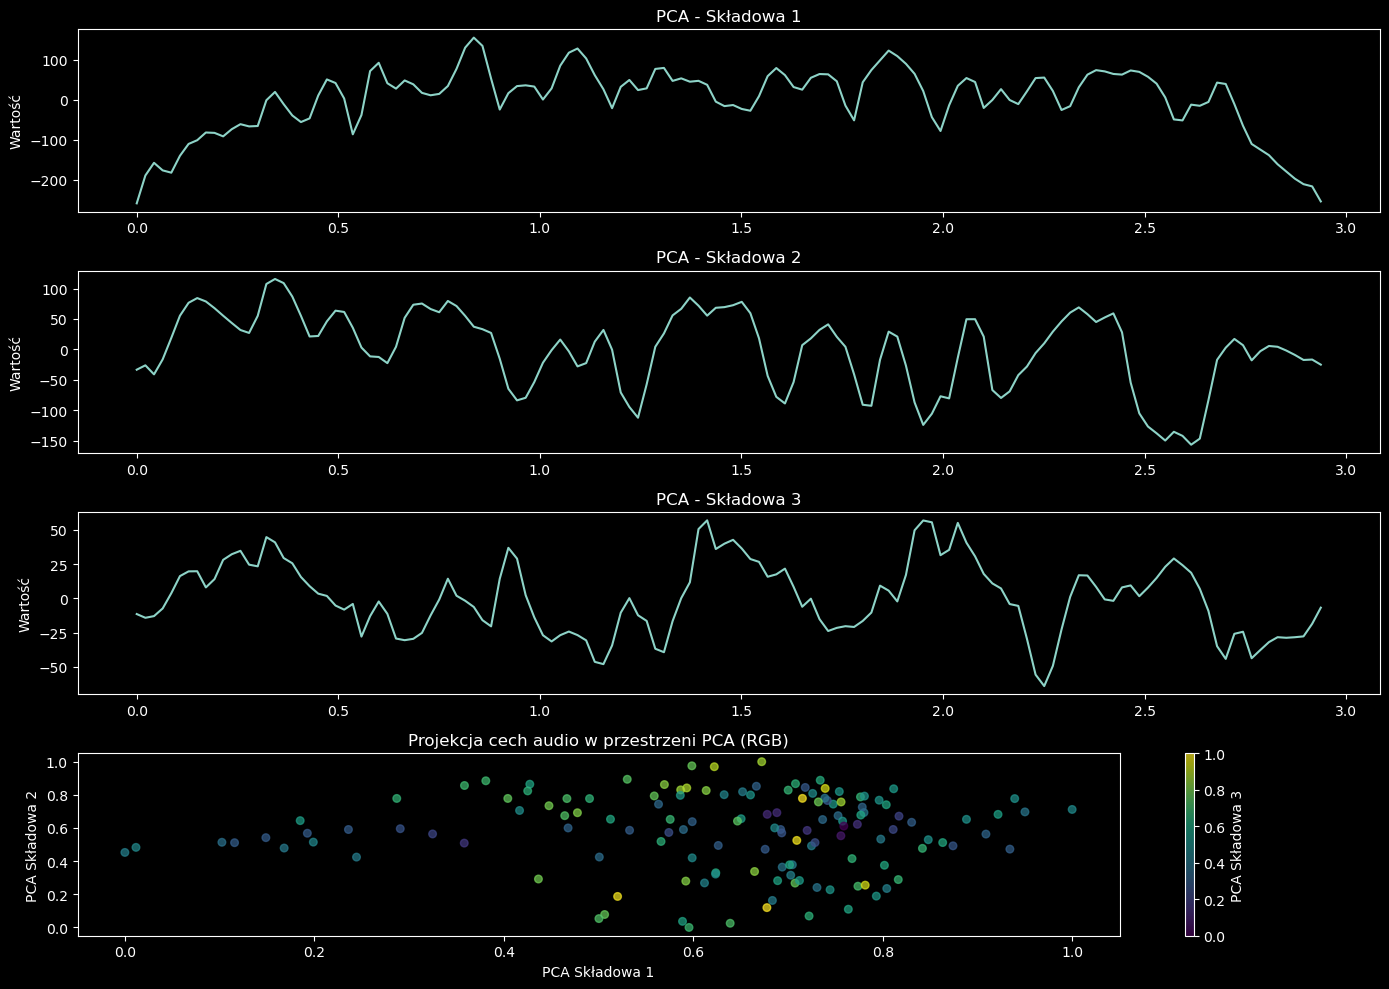

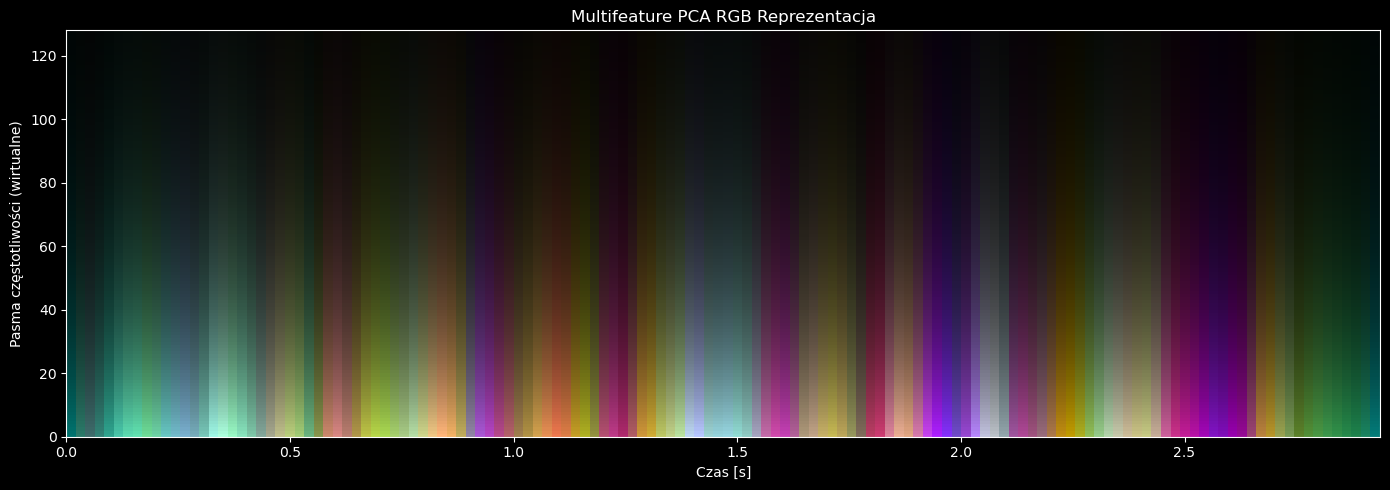

Porównanie mfcc_delta_visual dla różnych emocji: ['anger', 'fear', 'happiness', 'neutral', 'sadness', 'surprised']
Porównanie zapisano do: visualizations/comparison_mfcc_delta_visual.png


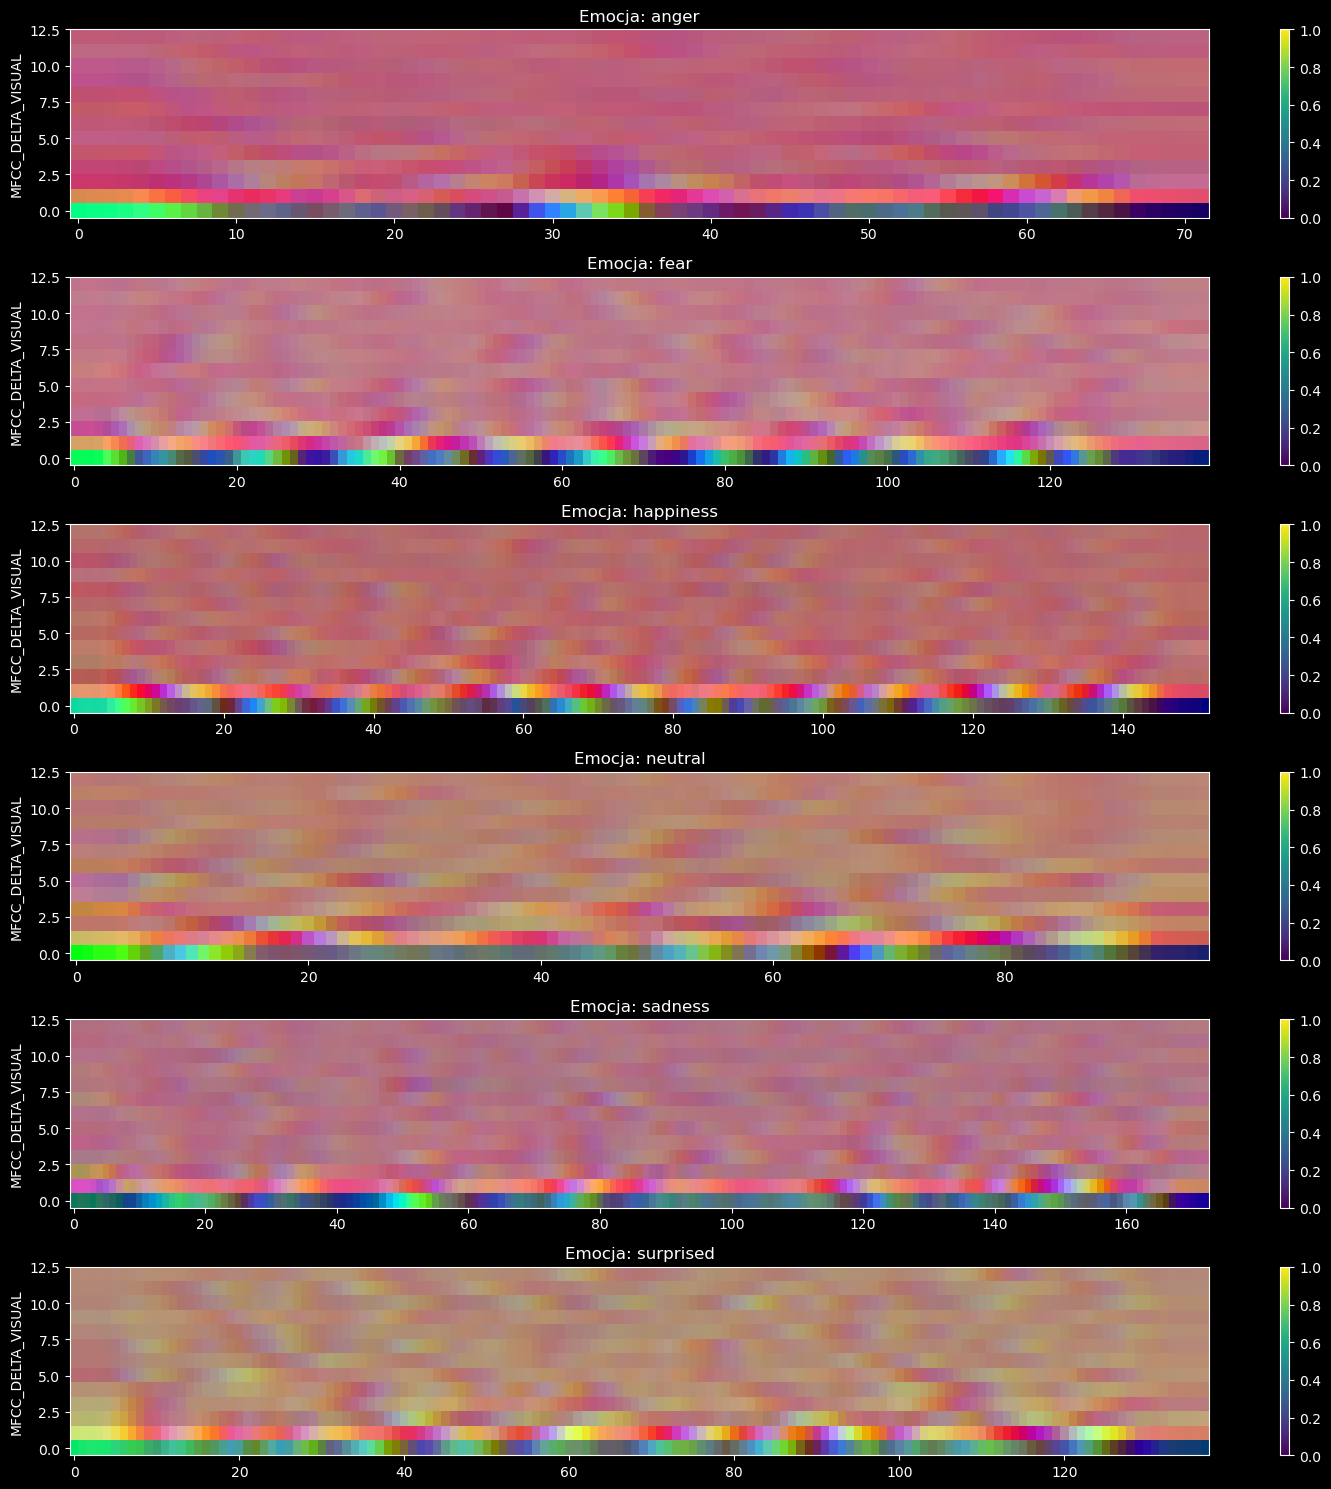

Porównanie cqt dla różnych emocji: ['anger', 'fear', 'happiness', 'neutral', 'sadness', 'surprised']
Porównanie zapisano do: visualizations/comparison_cqt.png


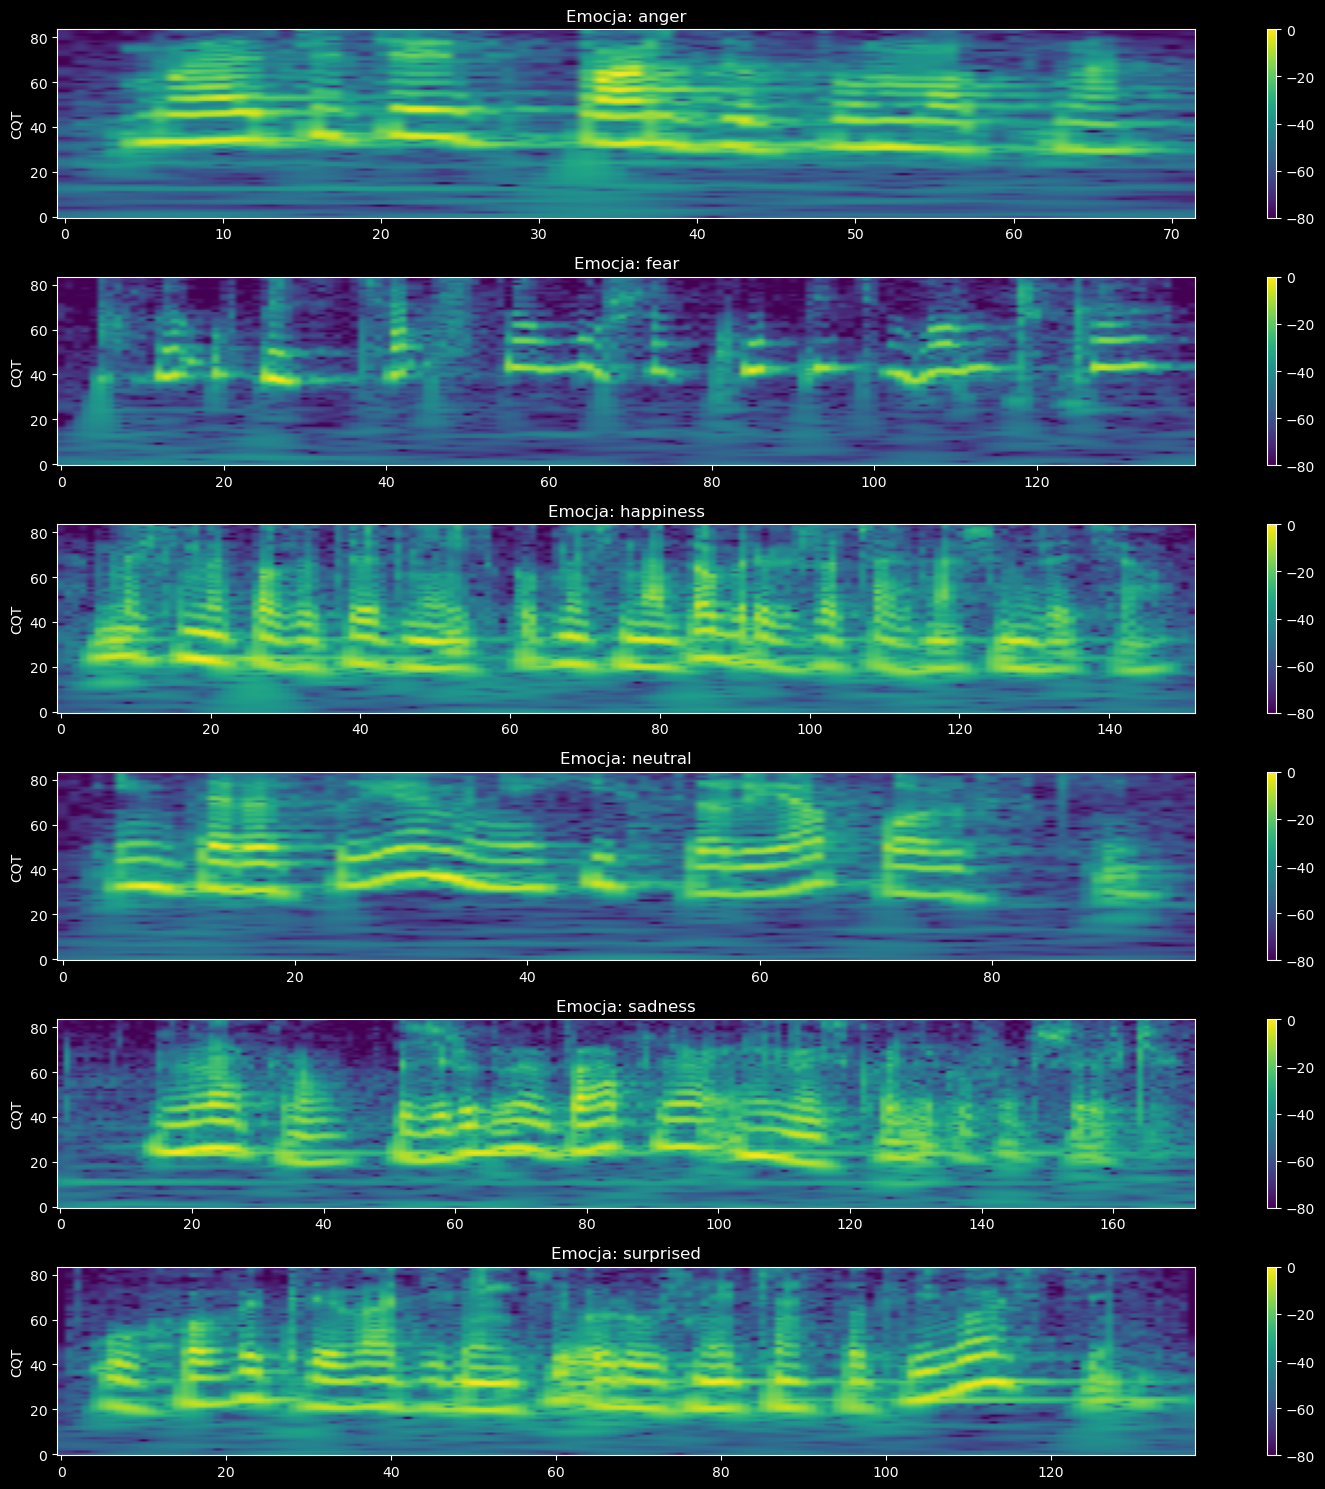

Porównanie tonal_contrast dla różnych emocji: ['anger', 'fear', 'happiness', 'neutral', 'sadness', 'surprised']
Porównanie zapisano do: visualizations/comparison_tonal_contrast.png


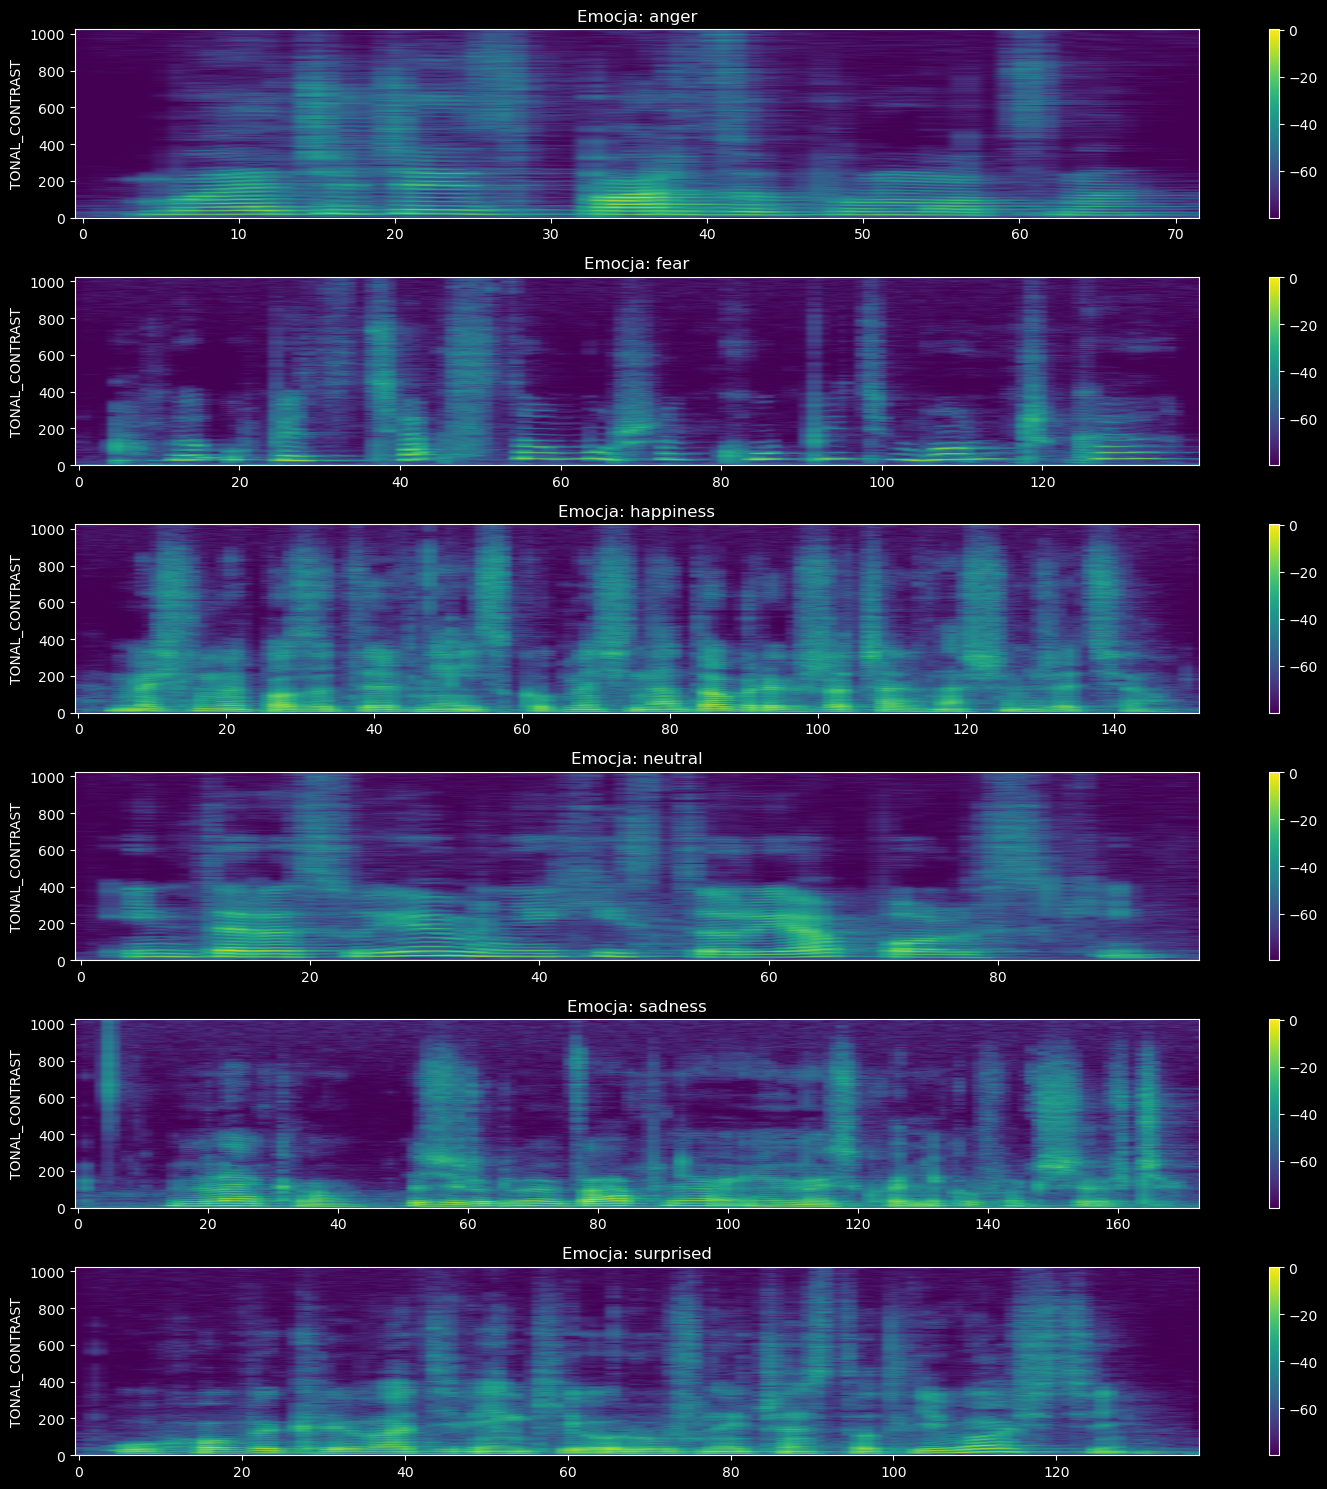

Porównanie harmonic_percussive dla różnych emocji: ['anger', 'fear', 'happiness', 'neutral', 'sadness', 'surprised']
Porównanie zapisano do: visualizations/comparison_harmonic_percussive.png


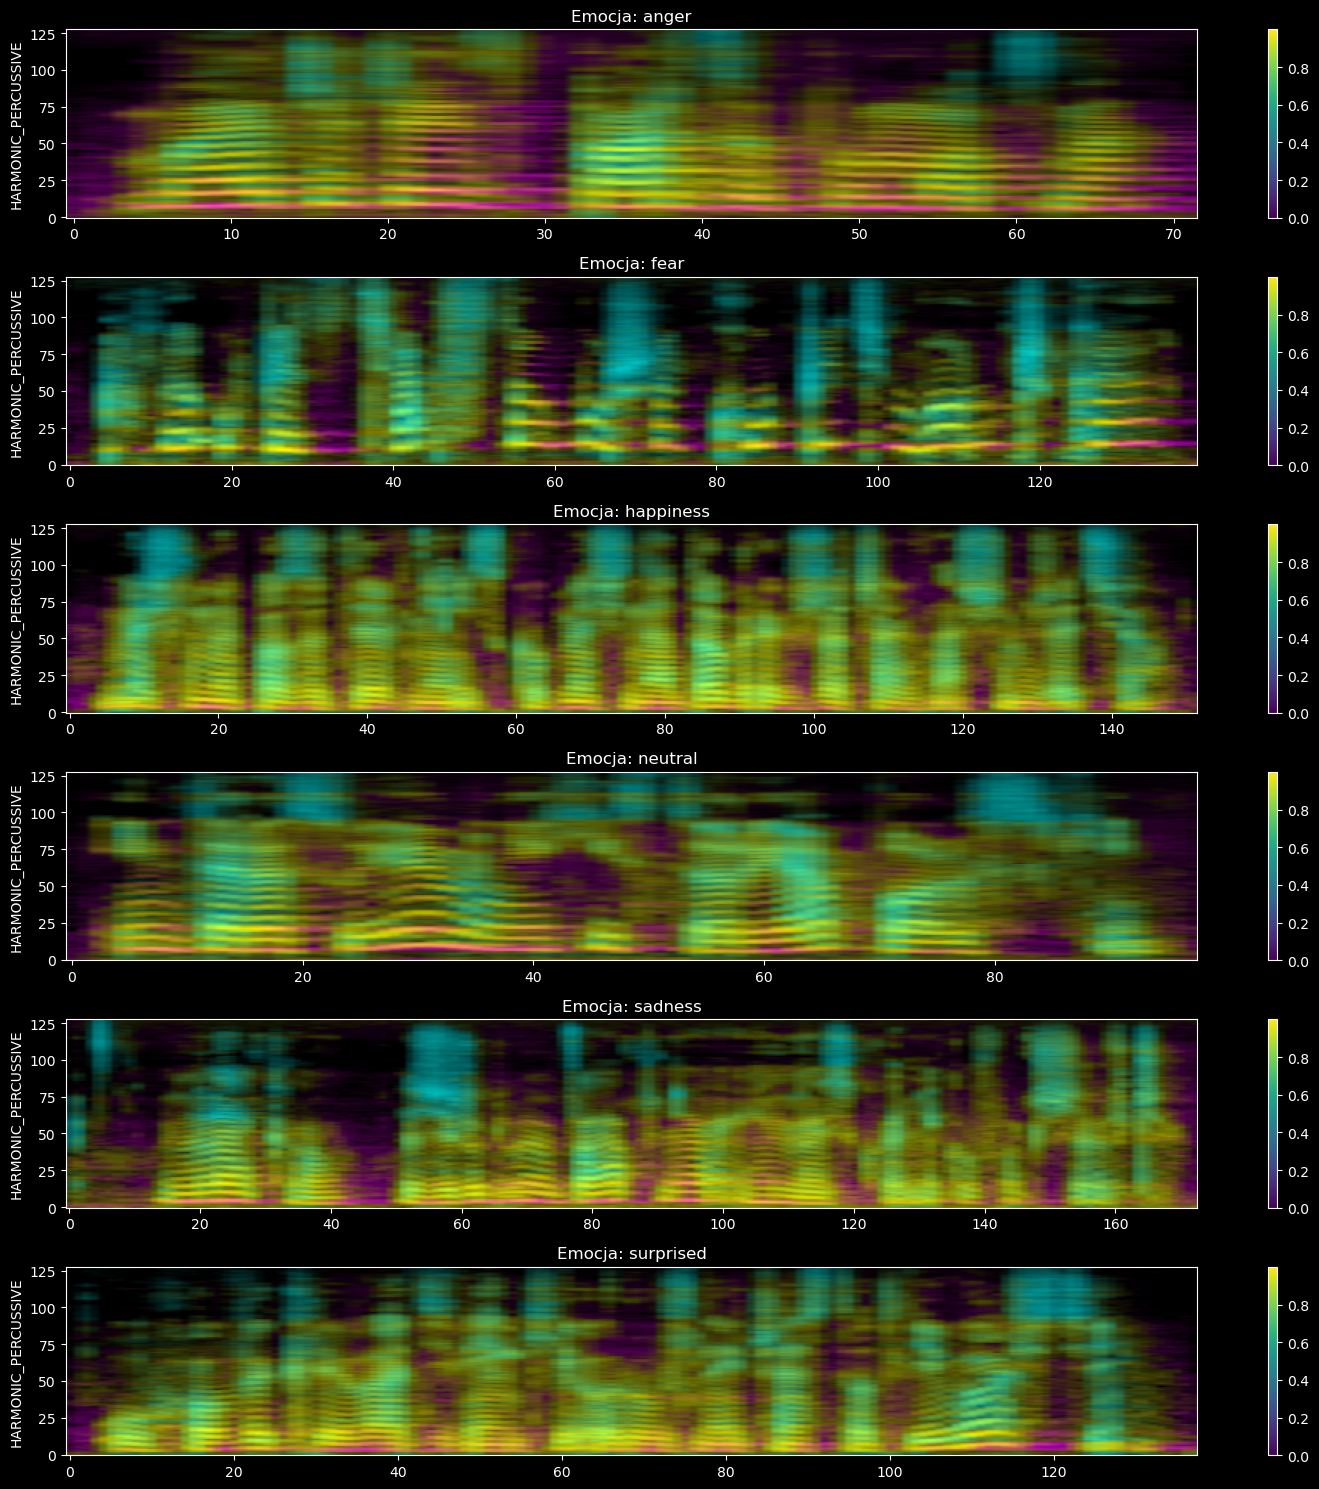

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa
from datasets import load_from_disk
import os
from sklearn.decomposition import PCA  # Dla wielowymiarowej reprezentacji PCA
import matplotlib.colors as mcolors  # Dla lepszej wizualizacji kolorów

#Tworzenie katalogu do przechowywania wykresów
visualizations_dir = 'visualizations'
if not os.path.exists(visualizations_dir):
    os.makedirs(visualizations_dir)
    print(f"Utworzono katalog: {visualizations_dir}")
else:
    print(f"Katalog {visualizations_dir} już istnieje. Wykresy będą zapisywane w tym katalogu.")


# 1. Wczytanie datasetu
print("Wczytywanie datasetu...")
dataset = load_from_disk('data/nemo_dataset')

plt.style.use('dark_background')

# 2. Funkcja odpowiedzialna za wizualizację i odtwarzanie audio z dodatkowymi wizualizacjami
def visualize_audio(idx=0, title=None, save_plots=True):
    
    # Uzyskanie próbki
    sample = dataset['train'][idx]
    audio_data = sample['audio']
    audio_array = audio_data['array']
    sr = audio_data['sampling_rate']
    
    # Utworzenie katalogu dla konkretnej próbki jeśli save_plots=True
    sample_dir = None
    if save_plots:
        sample_dir = os.path.join(visualizations_dir, f"sample_{idx}_{sample['emotion']}")
        if not os.path.exists(sample_dir):
            os.makedirs(sample_dir)

    # Prezentacja informacji o próbce
    if title:
        print(f"\n{title}")
    else:
        print(f"\nPróbka audio #{idx}")
        
    print(f"Emocja: {sample['emotion']}")
    print(f"Tekst: {sample['raw_text']}")
    print(f"Speaker ID: {sample['speaker_id']}")
    print(f"Częstotliwość próbkowania: {sr} Hz")
    print(f"Długość nagrania: {len(audio_array)/sr:.2f} sekund")
    
    # Odtwarzanie audio
    print("\nOdtwarzanie audio:")
    ipd.display(ipd.Audio(audio_array, rate=sr))
    
    # 1. Wizualizacja przebiegu fali dźwiękowej
    plt.figure(figsize=(14, 4))
    time = np.arange(0, len(audio_array)) / sr
    plt.plot(time, audio_array)
    plt.title('Przebieg fali dźwiękowej')
    plt.xlabel('Czas [s]')
    plt.ylabel('Amplituda')
    plt.tight_layout()
    if save_plots:
        plt.savefig(os.path.join(sample_dir, 'przebieg_fali.png'))
    plt.show()
 
    
    # 2. Generowanie spektrogramu
    try:
        plt.figure(figsize=(14, 5))
        D = librosa.stft(audio_array)
        D_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
        plt.imshow(D_db, aspect='auto', origin='lower', 
                   extent=[0, len(audio_array)/sr, 0, sr/2])
        plt.colorbar(format='%+2.0f dB')
        plt.title('Spektrogram')
        plt.ylabel('Częstotliwość [Hz]')
        plt.xlabel('Czas [s]')
        plt.tight_layout()
        if save_plots:
            plt.savefig(os.path.join(sample_dir, 'spektrogram.png'))
        plt.show()
    except Exception as e:
        print(f"Nie udało się wygenerować spektrogramu: {e}")
    
    # 3. Generowanie melspektrogramu
    try:
        plt.figure(figsize=(14, 5))
        mel_spect = librosa.feature.melspectrogram(y=audio_array, sr=sr)
        mel_spect_db = librosa.power_to_db(mel_spect, ref=np.max)
        plt.imshow(mel_spect_db, aspect='auto', origin='lower', 
                   extent=[0, len(audio_array)/sr, 0, 128])
        plt.colorbar(format='%+2.0f dB')
        plt.title('Melspektrogram')
        plt.ylabel('Filtry mel')
        plt.xlabel('Czas [s]')
        plt.tight_layout()
        if save_plots:
            plt.savefig(os.path.join(sample_dir, 'melspektrogram.png'))
        plt.show()
    except Exception as e:
        print(f"Nie udało się wygenerować melspektrogramu: {e}")
    
    # 4. Obliczanie MFCC (Mel-Frequency Cepstral Coefficients) - istotne dla rozpoznawania emocji
    try:
        plt.figure(figsize=(14, 5))
        mfccs = librosa.feature.mfcc(y=audio_array, sr=sr, n_mfcc=13)
        plt.imshow(mfccs, aspect='auto', origin='lower', 
                   extent=[0, len(audio_array)/sr, 0, 13])
        plt.colorbar()
        plt.title('MFCC - Mel-frequency cepstral coefficients')
        plt.ylabel('Współczynniki MFCC')
        plt.xlabel('Czas [s]')
        plt.tight_layout()
        if save_plots:
            plt.savefig(os.path.join(sample_dir, 'mfcc.png'))
        plt.show()
    except Exception as e:
        print(f"Nie udało się wygenerować MFCC: {e}")
        
    # 5. Obliczanie cech chromatycznych - reprezentacja tonalności dźwięku
    try:
        plt.figure(figsize=(14, 5))
        chroma = librosa.feature.chroma_stft(y=audio_array, sr=sr)
        plt.imshow(chroma, aspect='auto', origin='lower', 
                   extent=[0, len(audio_array)/sr, 0, 12])
        plt.colorbar()
        plt.title('Chromagram')
        plt.ylabel('Klasy wysokości (pitch)')
        plt.xlabel('Czas [s]')
        plt.tight_layout()
        if save_plots:
            plt.savefig(os.path.join(sample_dir, 'chromagram.png'))
        plt.show()
    except Exception as e:
        print(f"Nie udało się wygenerować chromagramu: {e}")
    
    # 6. Obliczanie kontrastu widmowego - istotne w analizie emocji mowy
    try:
        plt.figure(figsize=(14, 5))
        contrast = librosa.feature.spectral_contrast(y=audio_array, sr=sr)
        plt.imshow(contrast, aspect='auto', origin='lower', 
                   extent=[0, len(audio_array)/sr, 0, contrast.shape[0]])
        plt.colorbar()
        plt.title('Kontrast widmowy')
        plt.ylabel('Pasma częstotliwości')
        plt.xlabel('Czas [s]')
        plt.tight_layout()
        if save_plots:
            plt.savefig(os.path.join(sample_dir, 'kontrast_widmowy.png'))
        plt.show()
    except Exception as e:
        print(f"Nie udało się wygenerować kontrastu widmowego: {e}")
    
    # 7. Obliczanie wskaźnika zerowego przekroczenia - istotne w rozpoznawaniu emocji (np. szept, krzyk)
    try:
        plt.figure(figsize=(14, 4))
        zcr = librosa.feature.zero_crossing_rate(audio_array)
        plt.plot(np.linspace(0, len(audio_array)/sr, len(zcr[0])), zcr[0])
        plt.title('Zero Crossing Rate')
        plt.ylabel('ZCR')
        plt.xlabel('Czas [s]')
        plt.tight_layout()
        if save_plots:
            plt.savefig(os.path.join(sample_dir, 'zero_crossing_rate.png'))
        plt.show()
    except Exception as e:
        print(f"Nie udało się wygenerować ZCR: {e}")
    
    # 8. Obliczanie energii RMS - energia sygnału (głośność) - istotne dla emocji
    try:
        plt.figure(figsize=(14, 4))
        rms = librosa.feature.rms(y=audio_array)
        plt.plot(np.linspace(0, len(audio_array)/sr, len(rms[0])), rms[0])
        plt.title('RMS Energy')
        plt.ylabel('Energia')
        plt.xlabel('Czas [s]')
        plt.tight_layout()
        if save_plots:
            plt.savefig(os.path.join(sample_dir, 'rms_energy.png'))
        plt.show()
    except Exception as e:
        print(f"Nie udało się wygenerować RMS: {e}")
    
    # 9. Generowanie spektrogramu tempa - istotne do określenia dynamiki mowy
    try:
        plt.figure(figsize=(14, 5))
        onset_env = librosa.onset.onset_strength(y=audio_array, sr=sr)
        tempogram = librosa.feature.tempogram(onset_envelope=onset_env, sr=sr)
        plt.imshow(tempogram, aspect='auto', origin='lower', 
                  extent=[0, len(audio_array)/sr, 0, tempogram.shape[0]])
        plt.colorbar()
        plt.title('Tempogram')
        plt.ylabel('Tempo (BPM)')
        plt.xlabel('Czas [s]')
        plt.tight_layout()
        if save_plots:
            plt.savefig(os.path.join(sample_dir, 'tempogram.png'))
        plt.show()
    except Exception as e:
        print(f"Nie udało się wygenerować tempogramu: {e}")
    
    # 10. Obliczanie Tonnetz - reprezentacja tonalna dźwięku
    try:
        plt.figure(figsize=(14, 5))
        tonnetz = librosa.feature.tonnetz(y=audio_array, sr=sr)
        plt.imshow(tonnetz, aspect='auto', origin='lower', 
                   extent=[0, len(audio_array)/sr, 0, tonnetz.shape[0]])
        plt.colorbar()
        plt.title('Tonnetz - Reprezentacja tonalna')
        plt.ylabel('Wymiary tonalne')
        plt.xlabel('Czas [s]')
        plt.tight_layout()
        if save_plots:
            plt.savefig(os.path.join(sample_dir, 'tonnetz.png'))
        plt.show()
    except Exception as e:
        print(f"Nie udało się wygenerować tonnetz: {e}")
    
    # 11. Obliczanie delta tempogramu - zmiany w tempie
    try:
        plt.figure(figsize=(14, 5))
        onset_env = librosa.onset.onset_strength(y=audio_array, sr=sr)
        tempogram = librosa.feature.tempogram(onset_envelope=onset_env, sr=sr)
        delta_tempogram = np.diff(tempogram, axis=0)
        plt.imshow(delta_tempogram, aspect='auto', origin='lower', 
                  extent=[0, len(audio_array)/sr, 0, delta_tempogram.shape[0]])
        plt.colorbar()
        plt.title('Delta Tempogram - Zmiany tempa')
        plt.ylabel('Zmiana tempa')
        plt.xlabel('Czas [s]')
        plt.tight_layout()
        if save_plots:
            plt.savefig(os.path.join(sample_dir, 'delta_tempogram.png'))
        plt.show()
    except Exception as e:
        print(f"Nie udało się wygenerować delta tempogramu: {e}")
    
    # 12. Obliczanie delta MFCC - zmiany współczynników MFCC
    try:
        plt.figure(figsize=(14, 5))
        mfccs = librosa.feature.mfcc(y=audio_array, sr=sr, n_mfcc=13)
        delta_mfcc = librosa.feature.delta(mfccs)
        plt.imshow(delta_mfcc, aspect='auto', origin='lower', 
                   extent=[0, len(audio_array)/sr, 0, delta_mfcc.shape[0]])
        plt.colorbar()
        plt.title('Delta MFCC - Zmiany współczynników MFCC')
        plt.ylabel('Współczynniki delta MFCC')
        plt.xlabel('Czas [s]')
        plt.tight_layout()
        if save_plots:
            plt.savefig(os.path.join(sample_dir, 'delta_mfcc.png'))
        plt.show()
    except Exception as e:
        print(f"Nie udało się wygenerować delta MFCC: {e}")
        
    # NOWE WIZUALIZACJE:
    
    # 13. MFCC z Delta i Delta-Delta (wizualizacja RGB)
    try:
        plt.figure(figsize=(14, 5))
        mfccs = librosa.feature.mfcc(y=audio_array, sr=sr, n_mfcc=13)
        delta_mfcc = librosa.feature.delta(mfccs)
        delta2_mfcc = librosa.feature.delta(mfccs, order=2)
        
        # Normalizacja każdego kanału oddzielnie do zakresu [0, 1]
        mfcc_norm = (mfccs - np.min(mfccs)) / (np.max(mfccs) - np.min(mfccs) + 1e-8)
        delta_norm = (delta_mfcc - np.min(delta_mfcc)) / (np.max(delta_mfcc) - np.min(delta_mfcc) + 1e-8)
        delta2_norm = (delta2_mfcc - np.min(delta2_mfcc)) / (np.max(delta2_mfcc) - np.min(delta2_mfcc) + 1e-8)
        
        # Stackowanie w obraz RGB
        rgb_image = np.stack([mfcc_norm, delta_norm, delta2_norm], axis=-1)
        
        plt.imshow(rgb_image, aspect='auto', origin='lower',
                   extent=[0, len(audio_array)/sr, 0, 13])
        plt.title('MFCC Delta Visual (RGB: MFCC, Delta, Delta2)')
        plt.ylabel('Współczynniki MFCC')
        plt.xlabel('Czas [s]')
        plt.tight_layout()
        if save_plots:
            plt.savefig(os.path.join(sample_dir, 'mfcc_delta_visual.png'))
        plt.show()
    except Exception as e:
        print(f"Nie udało się wygenerować MFCC Delta Visual: {e}")
    
    # 14. Stała transformata Q (CQT)
    try:
        plt.figure(figsize=(14, 5))
        C = librosa.cqt(y=audio_array, sr=sr, hop_length=512, n_bins=84, bins_per_octave=12)
        C_db = librosa.amplitude_to_db(np.abs(C), ref=np.max)
        plt.imshow(C_db, aspect='auto', origin='lower',
                   extent=[0, len(audio_array)/sr, 0, 84])
        plt.colorbar(format='%+2.0f dB')
        plt.title('CQT - Stała transformata Q')
        plt.ylabel('Wysokość dźwięku (CQT)')
        plt.xlabel('Czas [s]')
        plt.tight_layout()
        if save_plots:
            plt.savefig(os.path.join(sample_dir, 'cqt.png'))
        plt.show()
    except Exception as e:
        print(f"Nie udało się wygenerować CQT: {e}")
    
    # 15. Spektrogram z uwydatnieniem tonalności (Tonal Contrast)
    try:
        plt.figure(figsize=(14, 5))
        # Generowanie standardowego spektrogramu
        D = librosa.stft(audio_array)
        S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
        
        # Dodatkowe przetwarzanie tonalne
        chroma = librosa.feature.chroma_stft(S=np.abs(D), sr=sr)
        tonnetz_features = librosa.feature.tonnetz(chroma=chroma, sr=sr)
        
        # Dopasowanie wymiarów i podkreślenie tonalności
        if tonnetz_features.shape[1] < S_db.shape[1]:
            ratio = S_db.shape[1] / tonnetz_features.shape[1]
            tonnetz_features = np.repeat(tonnetz_features, int(np.ceil(ratio)), axis=1)
            tonnetz_features = tonnetz_features[:, :S_db.shape[1]]
        
        # Normalizacja tonnetz przed dodaniem
        tonnetz_norm = (tonnetz_features - np.min(tonnetz_features)) / (np.max(tonnetz_features) - np.min(tonnetz_features) + 1e-8)
        
        # Wybór pierwszych trzech wymiarów tonnetz
        tonal_boost = np.mean(tonnetz_norm[:3, :], axis=0)
        tonal_boost = np.tile(tonal_boost, (S_db.shape[0], 1))
        
        # Wzmocnienie spektrogramu o informacje tonalne
        tonal_weight = 0.3
        tonal_enhanced = S_db + tonal_weight * tonal_boost
        
        # Normalizacja do celów wizualizacji
        tonal_enhanced = (tonal_enhanced - np.min(tonal_enhanced)) / (np.max(tonal_enhanced) - np.min(tonal_enhanced) + 1e-8)
        
        plt.imshow(tonal_enhanced, aspect='auto', origin='lower',
                  extent=[0, len(audio_array)/sr, 0, sr/2],
                  cmap='viridis')
        plt.colorbar()
        plt.title('Spektrogram z uwydatnieniem tonalności')
        plt.ylabel('Częstotliwość [Hz]')
        plt.xlabel('Czas [s]')
        plt.tight_layout()
        if save_plots:
            plt.savefig(os.path.join(sample_dir, 'tonal_contrast.png'))
        plt.show()
    except Exception as e:
        print(f"Nie udało się wygenerować spektrogramu z uwydatnieniem tonalności: {e}")
    
    # 16. Harmonic-Percussive Source Separation (HPSS)
    try:
        plt.figure(figsize=(14, 10))
        
        # Rozdzielenie sygnału na harmoniczne i perkusyjne komponenty
        y_harmonic, y_percussive = librosa.effects.hpss(audio_array)
        
        # Generowanie spektrogramów dla obu komponentów
        S_harmonic = librosa.feature.melspectrogram(y=y_harmonic, sr=sr)
        S_percussive = librosa.feature.melspectrogram(y=y_percussive, sr=sr)
        
        # Konwersja do skali dB
        S_harmonic_db = librosa.power_to_db(S_harmonic, ref=np.max)
        S_percussive_db = librosa.power_to_db(S_percussive, ref=np.max)
        
        # Normalizacja do wizualizacji RGB
        S_harm_norm = (S_harmonic_db - np.min(S_harmonic_db)) / (np.max(S_harmonic_db) - np.min(S_harmonic_db) + 1e-8)
        S_perc_norm = (S_percussive_db - np.min(S_percussive_db)) / (np.max(S_percussive_db) - np.min(S_percussive_db) + 1e-8)
        diff_norm = np.abs(S_harm_norm - S_perc_norm)
        
        # Tworzenie wizualizacji RGB
        rgb_hpss = np.stack([S_harm_norm, S_perc_norm, diff_norm], axis=-1)
        
        # Rysowanie wszystkich składników
        plt.subplot(3, 1, 1)
        plt.imshow(S_harm_norm, aspect='auto', origin='lower',
                  extent=[0, len(audio_array)/sr, 0, 128], cmap='Blues')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Komponenty harmoniczne')
        plt.ylabel('Filtry mel')
        
        plt.subplot(3, 1, 2)
        plt.imshow(S_perc_norm, aspect='auto', origin='lower',
                  extent=[0, len(audio_array)/sr, 0, 128], cmap='Oranges')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Komponenty perkusyjne')
        plt.ylabel('Filtry mel')
        
        plt.subplot(3, 1, 3)
        plt.imshow(rgb_hpss, aspect='auto', origin='lower',
                  extent=[0, len(audio_array)/sr, 0, 128])
        plt.title('Reprezentacja RGB - harmoniczne (R), perkusyjne (G), różnica (B)')
        plt.ylabel('Filtry mel')
        plt.xlabel('Czas [s]')
        
        plt.tight_layout()
        if save_plots:
            plt.savefig(os.path.join(sample_dir, 'harmonic_percussive.png'))
        plt.show()
    except Exception as e:
        print(f"Nie udało się wygenerować separacji harmonicznej-perkusyjnej: {e}")
    
    # 17. Wielowymiarowa reprezentacja cech z PCA
    try:
        # Ekstrakcja różnych cech
        mfcc = librosa.feature.mfcc(y=audio_array, sr=sr, n_mfcc=20)
        spectral_contrast = librosa.feature.spectral_contrast(y=audio_array, sr=sr)
        chroma = librosa.feature.chroma_stft(y=audio_array, sr=sr)
        
        # Przeskalowanie do wspólnej długości czasowej
        min_width = min(mfcc.shape[1], spectral_contrast.shape[1], chroma.shape[1])
        mfcc = mfcc[:, :min_width]
        spectral_contrast = spectral_contrast[:, :min_width]
        chroma = chroma[:, :min_width]
        
        # Łączenie cech
        features_stacked = np.vstack([mfcc, spectral_contrast, chroma])
        
        # Przygotowanie danych do PCA
        features_t = features_stacked.T
        
        # Zastosowanie PCA
        pca = PCA(n_components=3)
        pca_result = pca.fit_transform(features_t)
        
        # Normalizacja każdego kanału do zakresu [0,1]
        pca_normalized = np.zeros_like(pca_result)
        for i in range(3):
            pca_min, pca_max = np.min(pca_result[:, i]), np.max(pca_result[:, i])
            pca_range = pca_max - pca_min
            if pca_range > 0:
                pca_normalized[:, i] = (pca_result[:, i] - pca_min) / pca_range
        
        # Wizualizacja wyników
        plt.figure(figsize=(14, 10))
        
        # Pokazanie 3 głównych składowych PCA jako oddzielnych wykresów
        plt.subplot(4, 1, 1)
        plt.plot(np.linspace(0, len(audio_array)/sr, pca_result.shape[0]), pca_result[:, 0])
        plt.title('PCA - Składowa 1')
        plt.ylabel('Wartość')
        
        plt.subplot(4, 1, 2)
        plt.plot(np.linspace(0, len(audio_array)/sr, pca_result.shape[0]), pca_result[:, 1])
        plt.title('PCA - Składowa 2')
        plt.ylabel('Wartość')
        
        plt.subplot(4, 1, 3)
        plt.plot(np.linspace(0, len(audio_array)/sr, pca_result.shape[0]), pca_result[:, 2])
        plt.title('PCA - Składowa 3')
        plt.ylabel('Wartość')
        
        # Wizualizacja 2D z kolorami reprezentującymi trzecią składową
        plt.subplot(4, 1, 4)
        plt.scatter(
            pca_normalized[:, 0], 
            pca_normalized[:, 1], 
            c=pca_normalized[:, 2], 
            cmap='viridis',
            s=30,
            alpha=0.7
        )
        plt.colorbar(label='PCA Składowa 3')
        plt.title('Projekcja cech audio w przestrzeni PCA (RGB)')
        plt.xlabel('PCA Składowa 1')
        plt.ylabel('PCA Składowa 2')
        
        plt.tight_layout()
        if save_plots:
            plt.savefig(os.path.join(sample_dir, 'multifeature_pca.png'))
        plt.show()
        
        # Dodatkowa wizualizacja RGB obrazu
        plt.figure(figsize=(14, 5))
        # Przekształcenie 1D PCA do 2D obrazu
        n_mels = 128  # Wysokość obrazu
        pca_image = np.zeros((n_mels, pca_normalized.shape[0], 3))
        for i in range(n_mels):
            # Zmiana intensywności w zależności od położenia w spektrum
            intensity_factor = np.exp(-3.0 * (i / float(n_mels)))
            pca_image[i, :, :] = pca_normalized * intensity_factor
            
        plt.imshow(pca_image, aspect='auto', origin='lower', 
                  extent=[0, len(audio_array)/sr, 0, n_mels])
        plt.title('Multifeature PCA RGB Reprezentacja')
        plt.ylabel('Pasma częstotliwości (wirtualne)')
        plt.xlabel('Czas [s]')
        plt.tight_layout()
        if save_plots:
            plt.savefig(os.path.join(sample_dir, 'multifeature_pca_rgb.png'))
        plt.show()
        
    except Exception as e:
        print(f"Nie udało się wygenerować wielowymiarowej reprezentacji PCA: {e}")
    
    return sample

# 3. Prezentacja konkretnej próbki audio
print("Wyświetlanie próbki audio:")
try:
    visualize_audio(0)  # Indeks można zmienić, aby zobaczyć inną próbkę
except Exception as e:
    print(f"Błąd podczas przetwarzania próbki: {e}")

# 4. Funkcja do porównania cech audio dla różnych emocji
# Rozszerzenie funkcji compare_feature_across_emotions o więcej cech
def compare_feature_across_emotions(feature_name='mfcc', num_examples=1, save_plot=True):
    """Porównanie cechy audio dla różnych emocji."""
    # Uzyskanie unikalnych emocji
    emotions = sorted(set(dataset['train']['emotion']))
    print(f"Porównanie {feature_name} dla różnych emocji: {emotions}")
    
    # Dla każdej emocji uzyskanie pierwszego przykładu
    plt.figure(figsize=(15, len(emotions)*2.5))
    
    for i, emotion in enumerate(emotions):
        # Uzyskanie indeksu pierwszego elementu z daną emocją
        indices = [idx for idx, e in enumerate(dataset['train']['emotion']) if e == emotion]
        if indices and i < len(emotions):  # Zmienione z num_examples, aby pokazać wszystkie emocje
            sample = dataset['train'][indices[0]]
            audio_array = sample['audio']['array']
            sr = sample['audio']['sampling_rate']
            
            plt.subplot(len(emotions), 1, i+1)
            
            try:
                # Istniejące typy cech
                if feature_name == 'mfcc':
                    feature = librosa.feature.mfcc(y=audio_array, sr=sr, n_mfcc=13)
                    plt.imshow(feature, aspect='auto', origin='lower')
                elif feature_name == 'mel':
                    feature = librosa.feature.melspectrogram(y=audio_array, sr=sr)
                    feature_db = librosa.power_to_db(feature, ref=np.max)
                    plt.imshow(feature_db, aspect='auto', origin='lower')
                elif feature_name == 'chroma':
                    feature = librosa.feature.chroma_stft(y=audio_array, sr=sr)
                    plt.imshow(feature, aspect='auto', origin='lower')
                elif feature_name == 'zcr':
                    feature = librosa.feature.zero_crossing_rate(audio_array)
                    plt.plot(np.linspace(0, len(audio_array)/sr, len(feature[0])), feature[0])
                elif feature_name == 'rms':
                    feature = librosa.feature.rms(y=audio_array)
                    plt.plot(np.linspace(0, len(audio_array)/sr, len(feature[0])), feature[0])
                elif feature_name == 'spectral_contrast':
                    feature = librosa.feature.spectral_contrast(y=audio_array, sr=sr)
                    plt.imshow(feature, aspect='auto', origin='lower')
                
                # Nowe typy cech
                elif feature_name == 'mfcc_delta_visual':
                    mfccs = librosa.feature.mfcc(y=audio_array, sr=sr, n_mfcc=13)
                    delta_mfcc = librosa.feature.delta(mfccs)
                    delta2_mfcc = librosa.feature.delta(mfccs, order=2)
                    mfcc_norm = (mfccs - np.min(mfccs)) / (np.max(mfccs) - np.min(mfccs) + 1e-8)
                    delta_norm = (delta_mfcc - np.min(delta_mfcc)) / (np.max(delta_mfcc) - np.min(delta_mfcc) + 1e-8)
                    delta2_norm = (delta2_mfcc - np.min(delta2_mfcc)) / (np.max(delta2_mfcc) - np.min(delta2_mfcc) + 1e-8)
                    feature = np.stack([mfcc_norm, delta_norm, delta2_norm], axis=-1)
                    plt.imshow(feature, aspect='auto', origin='lower')
                
                elif feature_name == 'cqt':
                    C = librosa.cqt(y=audio_array, sr=sr, hop_length=512)
                    feature = librosa.amplitude_to_db(np.abs(C), ref=np.max)
                    plt.imshow(feature, aspect='auto', origin='lower')
                    
                elif feature_name == 'tonal_contrast':
                    D = librosa.stft(audio_array)
                    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
                    chroma = librosa.feature.chroma_stft(S=np.abs(D), sr=sr)
                    tonnetz_features = librosa.feature.tonnetz(chroma=chroma, sr=sr)
                    if tonnetz_features.shape[1] < S_db.shape[1]:
                        ratio = S_db.shape[1] / tonnetz_features.shape[1]
                        tonnetz_features = np.repeat(tonnetz_features, int(np.ceil(ratio)), axis=1)
                        tonnetz_features = tonnetz_features[:, :S_db.shape[1]]
                    tonnetz_norm = (tonnetz_features - np.min(tonnetz_features)) / (np.max(tonnetz_features) - np.min(tonnetz_features) + 1e-8)
                    tonal_boost = np.mean(tonnetz_norm[:3, :], axis=0)
                    tonal_boost = np.tile(tonal_boost, (S_db.shape[0], 1))
                    tonal_weight = 0.3
                    feature = S_db + tonal_weight * tonal_boost
                    plt.imshow(feature, aspect='auto', origin='lower', cmap='viridis')
                    
                elif feature_name == 'harmonic_percussive':
                    y_harmonic, y_percussive = librosa.effects.hpss(audio_array)
                    S_harmonic = librosa.feature.melspectrogram(y=y_harmonic, sr=sr)
                    S_percussive = librosa.feature.melspectrogram(y=y_percussive, sr=sr)
                    S_harmonic_db = librosa.power_to_db(S_harmonic, ref=np.max)
                    S_percussive_db = librosa.power_to_db(S_percussive, ref=np.max)
                    S_harm_norm = (S_harmonic_db - np.min(S_harmonic_db)) / (np.max(S_harmonic_db) - np.min(S_harmonic_db) + 1e-8)
                    S_perc_norm = (S_percussive_db - np.min(S_percussive_db)) / (np.max(S_percussive_db) - np.min(S_percussive_db) + 1e-8)
                    diff = np.abs(S_harm_norm - S_perc_norm)
                    feature = np.stack([S_harm_norm, S_perc_norm, diff], axis=-1)
                    plt.imshow(feature, aspect='auto', origin='lower')
                
                plt.title(f"Emocja: {emotion}")
                plt.ylabel(feature_name.upper())
                if feature_name not in ['zcr', 'rms']:
                    plt.colorbar(format='%+2.0f dB' if feature_name == 'mel' else None)
            except Exception as e:
                print(f"Błąd podczas generowania {feature_name} dla emocji {emotion}: {e}")
    
    plt.tight_layout()
    if save_plot:
        plot_path = os.path.join(visualizations_dir, f'comparison_{feature_name}.png')
        plt.savefig(plot_path)
        print(f"Porównanie zapisano do: {plot_path}")
    
    plt.show()

# Porównanie nowych reprezentacji dla różnych emocji
compare_feature_across_emotions('mfcc_delta_visual')
compare_feature_across_emotions('cqt')
compare_feature_across_emotions('tonal_contrast')
compare_feature_across_emotions('harmonic_percussive')